In [11]:
# Lê Hoài Linh
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")
!pip install catboost
!pip install shap
!pip install feature_engine

import matplotlib.pyplot as plt
from catboost import Pool, CatBoostClassifier
from feature_engine.encoding import RareLabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import itertools
pd.set_option('display.max_rows', 1000)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 328.9/328.9 kB 5.1 MB/s eta 0:00:00


In [8]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
df = pd.read_csv("/content/drive/MyDrive/Ransomware Attacks - Ransomware Attacks.csv").drop_duplicates()
print(df.shape)
df.sample(5).T

(358, 29)


,286,306,204,84,255
Target,Managed.com,Honda,DNM,SN,SK Hynix
AKA,NaN,NaN,Dirección Nacional de Migraciones,SN Servicing Corporation,NaN
description,leading web hosting solutions provider,NaN,NaN,NaN,world's second largest memory chip maker
sector,tech,automotive,government,finance,tech
"organisation size 1,5,10,25,100,300",1,300,1,10,100
revenue $USD million,5.0,119697.0,1.0,100.0,28538.0
cost,500000,unknown,4,unknown,unknown
ransom cost,0.5,NaN,4.0,NaN,NaN
data note,NaN,NaN,NaN,NaN,NaN
ransom paid,unknown,unknown,refused,unknown,unknown


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 358 entries, 0 to 357
Data columns (total 29 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Target                                358 non-null    object 
 1   AKA                                   67 non-null     object 
 2   description                           184 non-null    object 
 3   sector                                351 non-null    object 
 4   organisation size 1,5,10,25,100,300   358 non-null    int64  
 5   revenue $USD million                  333 non-null    float64
 6   cost                                  358 non-null    object 
 7   ransom cost                           113 non-null    float64
 8   data note                             26 non-null     object 
 9   ransom paid                           358 non-null    object 
 10  YEAR code                             358 non-null    int64  
 11  YEAR               

In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
"organisation size 1,5,10,25,100,300",358.0,24.083799,48.505724,1.0000,5.000,10.0,25.00,300.0
revenue $USD million,333.0,9700.189189,32588.567273,0.0000,28.000,665.0,3430.00,399000.0
ransom cost,113.0,32.954465,87.693550,0.0025,0.457,4.9,24.00,670.0
YEAR code,358.0,2.329609,1.534940,1.0000,1.000,2.0,3.00,6.0
YEAR,358.0,2019.631285,1.647789,2013.0000,2019.000,2020.0,2021.00,2021.0
interesting story (edited),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Source Name,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
#ID,358.0,179.932961,103.916072,1.0000,90.250,179.5,269.75,359.0


In [14]:
df['ransom paid'].value_counts()

unknown        266
refused         60
ransom paid     31
no               1
Name: ransom paid, dtype: int64

In [15]:
df['month'].value_counts()

MAY     59
JUN     46
APR     38
MAR     35
JAN     33
FEB     32
NOV     28
OCT     21
SEP     19
AUG     15
DEC     13
JUL     12
JUN      2
Name: month, dtype: int64

In [17]:
# select main label
main_label = 'ransom paid'
df[main_label] = (df['ransom paid']=='ransom paid').astype(int)
# rename some columns
replace_dict = {'organisation size 1,5,10,25,100,300 ': 'org size'}
df = df.rename(columns=replace_dict)
# convert columns to string
for col in ['YEAR', 'org size', 'month']:
  df[col] = df[col].fillna('None').astype(str)
# set up the rare label encoder limiting number of categories to max_n_categories
for col in ['YEAR', 'org size', 'location', 'Ransomware', 'sector']:
  df[col] = df[col].fillna('None')
encoder = RareLabelEncoder(n_categories=1, max_n_categories=70, replace_with='Other', tol=10/df.shape[0])
df[col] = encoder.fit_transform(df[[col]])
# finally, drop unused columns
cols2drop = ['Target', 'AKA', 'description ', 'ransom cost', 'revenue $USD million ', 'interesting story (edited)', 'Source Name', '#ID',
'stock symbol', 'revenue as of', 'no of employees', 'Data Note', 'Source Name', 'URL', 'URL 2', 'URL 3', 'URL 4',
'URL 5', 'YEAR code', 'interesting story (long)', 'interesting story?', 'cost', 'data note']

df = df.drop(cols2drop, axis=1)
print(df.shape)
df.sample(5).T

(358, 7)


,332,189,249,80,346
sector,government,tech,logistics,academic,healthcare
org size,10,25,25,1,10
ransom paid,0,0,1,0,1
YEAR,2018,2021,2020,2021,2016
month,SEP,MAY,AUG,FEB,FEB
location,USA,USA,USA,USA,USA
Ransomware,SamSam,Not revealed,Ragnar Locker,unknown,Not revealed


In [18]:
# initialize data
y = df[main_label].values.reshape(-1,)
X = df.drop([main_label], axis=1)
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols_idx = [list(X.columns).index(c) for c in cat_cols]
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.5, random_state=0, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((179, 6), (179, 6), (179,), (179,))

In [19]:
from sklearn.utils.class_weight import compute_class_weight
# add class weights to handle imbalanced classes
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))
print(class_weights)

{0: 0.549079754601227, 1: 5.59375}


In [20]:
# initialize Pool
train_pool = Pool(X_train,
y_train,
cat_features=cat_cols_idx)

test_pool = Pool(X_test,
y_test,
cat_features=cat_cols_idx)
# specify the training parameters
model = CatBoostClassifier(iterations=50,
depth=5,
border_count=20,
l2_leaf_reg=0.4,
learning_rate=1e-1,
class_weights=class_weights,
verbose=0)

#train the model
model.fit(train_pool)
# make the prediction using the resulting model
y_train_pred = model.predict_proba(train_pool)[:,1]
y_test_pred = model.predict_proba(test_pool)[:,1]
roc_auc_train = roc_auc_score(y_train, y_train_pred)
roc_auc_test = roc_auc_score(y_test, y_test_pred)
print(f"ROC AUC score for train {round(roc_auc_train,4)}, and for test {round(roc_auc_test,4)}")

ROC AUC score for train 0.8763, and for test 0.6484


In [21]:
# calculating the baseline ROC AUC score assuming the same probability from training labels to test
roc_auc_baseline = roc_auc_score(y_test, [np.mean(y_train)]*len(y_test))
print(roc_auc_baseline)

0.5


Accuracy: 0.8156
F1 Score: 0.1538


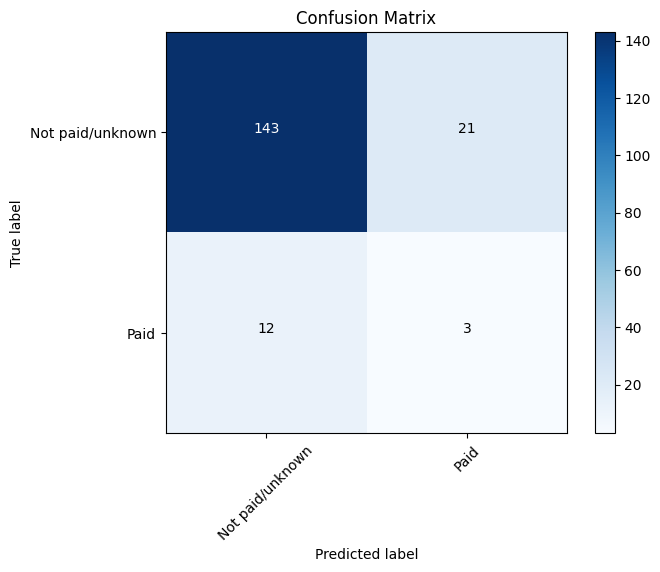

In [32]:
# plotting confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
  """
  This function plots a confusion matrix.
  Parameters:
    cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
    classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
    title (str): Title for the plot.
    cmap (matplotlib colormap): Colormap for the plot.
  """
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)
  fmt = '.0f'
  thresh = cm.max() / 2.0
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
# Calculate accuracy and F1 score
accuracy = accuracy_score(y_test, (y_test_pred > 0.5))
f1 = f1_score(y_test, (y_test_pred > 0.5))
# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
# Get the confusion matrix
cm = confusion_matrix(y_test, (y_test_pred > 0.5))
# Plot the confusion matrix
class_names = ['Not paid/unknown', 'Paid'] # positive class should come the last
plot_confusion_matrix(cm, class_names)

Average ransom paid probability is 0.0838


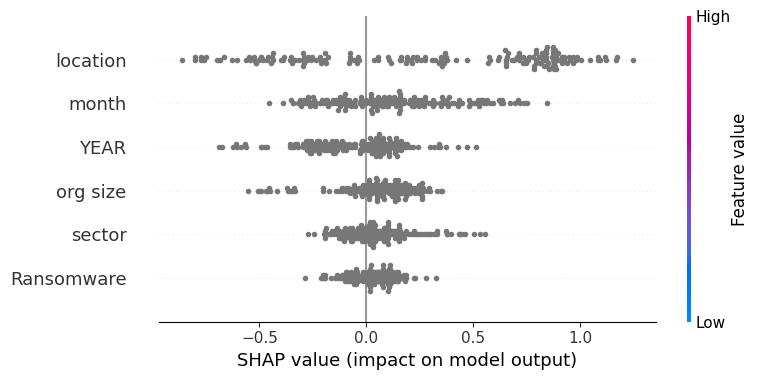

In [33]:
import shap
import numpy as np
# Install SHAP if it's not already installed
!pip install shap
# Assuming you have defined and trained your model, and X_test, y_test are defined
# model = ...
# Create a TreeExplainer for your model
ex = shap.TreeExplainer(model)
# Print the average ransom paid probability on the test set
print(f"Average ransom paid probability is {round(np.mean(y_test), 4)}")
# Compute SHAP values for your test set
shap_values = ex.shap_values(X_test)
# Generate a summary plot of the SHAP values
shap.summary_plot(shap_values, X_test, max_display=30)


sector



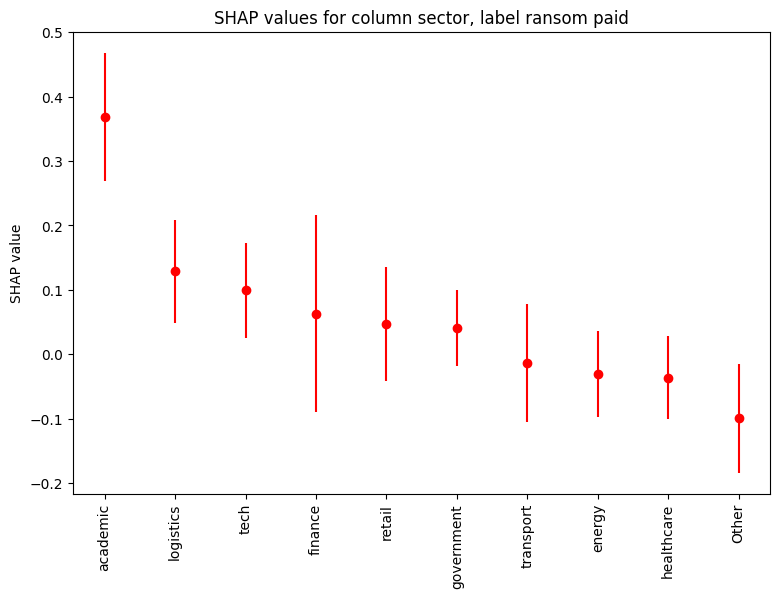

              gain  gain_std  count
col                                
academic    0.3682    0.1000     20
logistics   0.1285    0.0802     11
tech        0.0989    0.0732     26
finance     0.0629    0.1532     11
retail      0.0469    0.0889     10
government  0.0402    0.0588     32
transport  -0.0138    0.0919      5
energy     -0.0308    0.0667      7
healthcare -0.0365    0.0648     24
Other      -0.0999    0.0842     33

org size



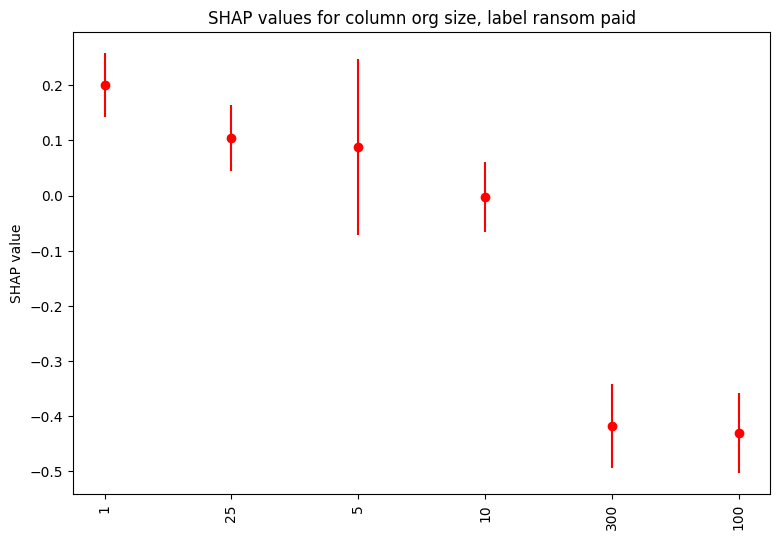

       gain  gain_std  count
col                         
1    0.2010    0.0580     38
25   0.1046    0.0598     48
5    0.0879    0.1594     28
10  -0.0030    0.0631     50
300 -0.4186    0.0767      4
100 -0.4311    0.0725     11

YEAR



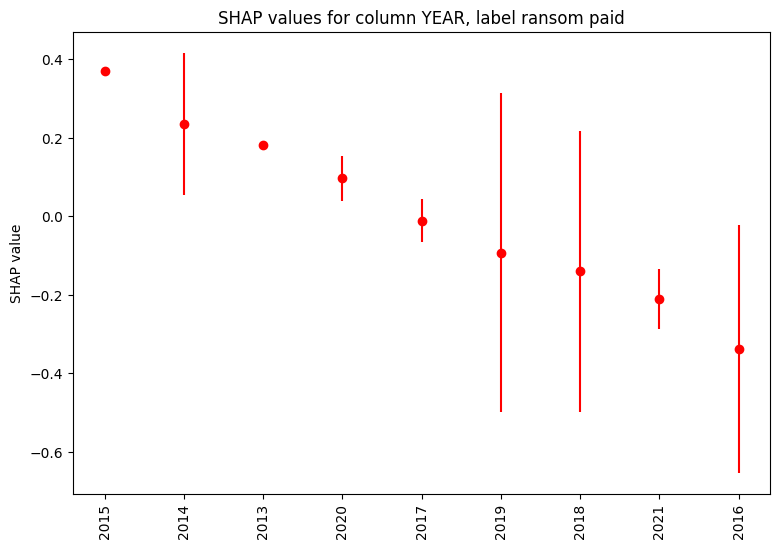

        gain  gain_std  count
col                          
2015  0.3709       NaN      1
2014  0.2346    0.1814      3
2013  0.1804       NaN      1
2020  0.0964    0.0580     60
2017 -0.0109    0.0542     17
2019 -0.0932    0.4067     19
2018 -0.1399    0.3582      6
2021 -0.2112    0.0770     66
2016 -0.3381    0.3161      6

month



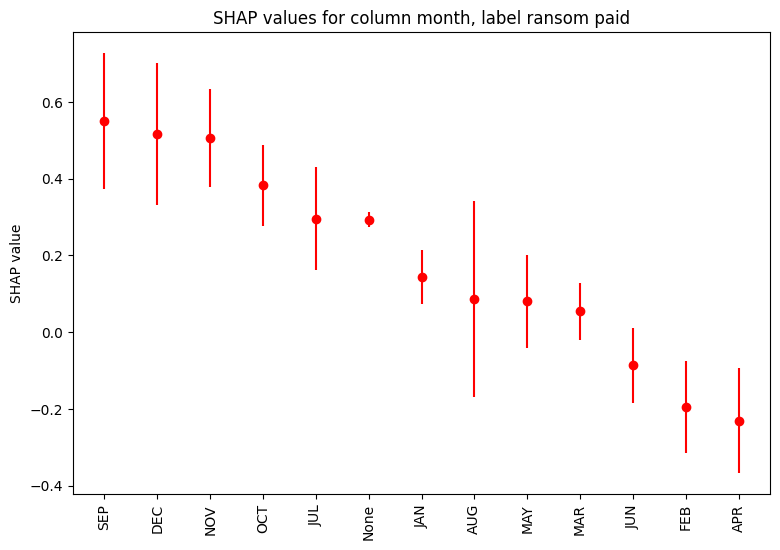

        gain  gain_std  count
col                          
SEP   0.5501    0.1768     10
DEC   0.5170    0.1851      7
NOV   0.5052    0.1277     19
OCT   0.3822    0.1047     10
JUL   0.2956    0.1348      4
None  0.2931    0.0193      3
JAN   0.1443    0.0698     17
AUG   0.0862    0.2552      8
MAY   0.0803    0.1205     25
MAR   0.0540    0.0742     19
JUN  -0.0860    0.0980     22
FEB  -0.1940    0.1198     14
APR  -0.2307    0.1367     21

location



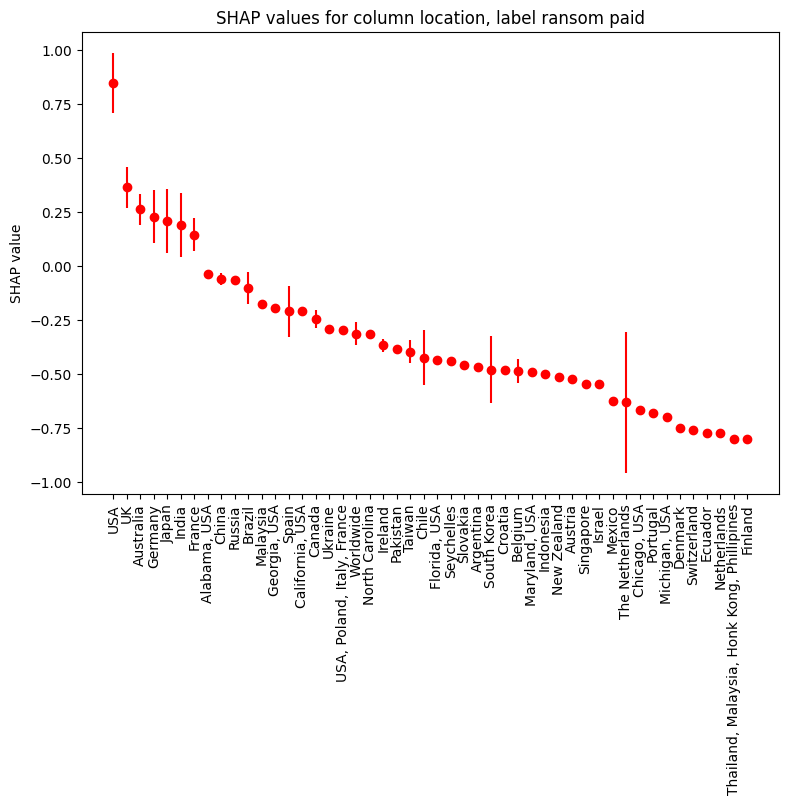

                                              gain  gain_std  count
col                                                                
USA                                         0.8475    0.1401     82
UK                                          0.3647    0.0953     12
Australia                                   0.2638    0.0718      7
Germany                                     0.2288    0.1241      3
Japan                                       0.2072    0.1484      3
India                                       0.1879    0.1483      3
France                                      0.1457    0.0763      7
Alabama, USA                               -0.0365       NaN      1
China                                      -0.0605    0.0288      2
Russia                                     -0.0666    0.0120      2
Brazil                                     -0.1018    0.0761      3
Malaysia                                   -0.1776       NaN      1
Georgia, USA                               -0.19

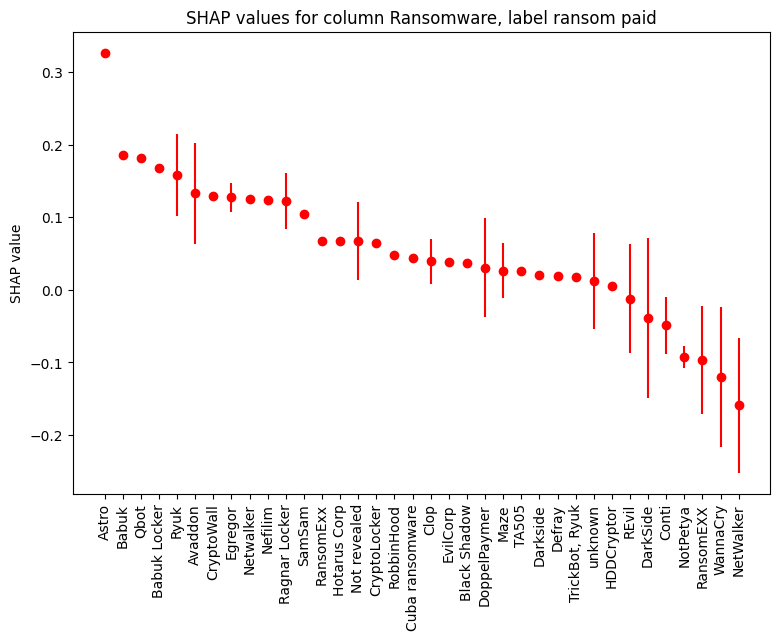

                   gain  gain_std  count
col                                     
Astro            0.3266       NaN      1
Babuk            0.1853       NaN      1
Qbot             0.1815       NaN      1
Babuk Locker     0.1681       NaN      1
Ryuk             0.1579    0.0563     14
Avaddon          0.1326    0.0692      2
CryptoWall       0.1293    0.0036      2
Egregor          0.1273    0.0195      6
Netwalker        0.1246       NaN      1
Nefilim          0.1238       NaN      1
Ragnar Locker    0.1225    0.0383      2
SamSam           0.1045       NaN      1
RansomExx        0.0675       NaN      1
Hotarus Corp     0.0675       NaN      1
Not revealed     0.0672    0.0531     26
CryptoLocker     0.0650       NaN      1
RobbinHood       0.0479       NaN      1
Cuba ransomware  0.0440       NaN      1
Clop             0.0393    0.0312      7
EvilCorp         0.0379       NaN      1
Black Shadow     0.0364       NaN      1
DoppelPaymer     0.0304    0.0681      9
Maze            

In [34]:
def show_shap(col, shap_values=shap_values, label=main_label, X_test=X_test, ylabel='SHAP value'):
  df_infl = X_test.copy()
  df_infl['shap_'] = shap_values[:,df_infl.columns.tolist().index(col)]
  gain = round(df_infl.groupby(col).mean()['shap_'],4)
  gain_std = round(df_infl.groupby(col).std()['shap_'],4)
  cnt = df_infl.groupby(col).count()['shap_']
  dd_dict = {'col': list(gain.index), 'gain': list(gain.values), 'gain_std': list(gain_std.values), 'count': cnt}
  df_res = pd.DataFrame.from_dict(dd_dict).sort_values('gain', ascending=False).set_index('col')
  plt.figure(figsize=(9,6))
  plt.errorbar(df_res.index, df_res['gain'], yerr=df_res['gain_std'], fmt="o", color="r")
  plt.title(f'SHAP values for column {col}, label {label}')
  plt.ylabel(ylabel)
  plt.tick_params(axis="x", rotation=90)
  plt.show();
  print(df_res)
  return
for col in X_test.columns:
  print()
  print(col)
  print()
  show_shap(col, shap_values, label=main_label, X_test=X_test)